In [20]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#import tyssue
import sys
sys.path.append('/home/guillaume/Python/tyssue/src')
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize


from tyssue.core.generation import data_dicts
from tyssue.utils.utils import set_data_columns
from tyssue.core.sheet import Sheet

from tyssue.utils.utils import set_data_columns

import tyssue.geometry.sheet_geometry as geom
import tyssue.dynamics.sheet_vertex_model as model
import tyssue.solvers.sheet_vertex_solver as solver

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax



from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.io import hdf5

In [33]:
datasets = hdf5.load_datasets('before_apoptosis.hf5')

sheet = Sheet('pola', datasets, data_dicts)
sheet.set_geom(geom)
geom_spec = geom.get_default_geom_specs()
geom.update_all(sheet)

mod_specs, dim_mod_specs = sheet.set_model(model)
sheet.nrj_norm_factor = dim_mod_specs['settings']['nrj_norm_factor']
isotropic_relax(sheet)



In [34]:
%matplotlib inline

```python
local_mask_jv = (sheet.jv_df.x.abs() < 20) & (sheet.jv_df.z.abs() < 10) & (sheet.jv_df.y > 0)
local_patch_jv = sheet.jv_df[local_mask_jv] 
local_patch_je = sheet.je_df[sheet.upcast_srce(local_mask_jv) & sheet.upcast_trgt(local_mask_jv)]
local_patch_face = sheet.face_df.loc[np.unique(local_patch_je.index.get_level_values('face'))]
local_datasets = {'jv': local_patch_jv,
                  'je': local_patch_je,
                  'face':local_patch_face}
local_sheet = Sheet('local', local_datasets)
```

In [35]:
sheet.jv_df.head()

,is_active,z,x,y,old_idx,basal_shift,rho,height,radial_tension
jv,,,,,,,,,
0,0,-66.539375,37.750631,-0.547874,928,28.985131,37.754607,8.769476,0
1,0,-65.598786,38.179827,2.820791,929,28.985131,38.283888,9.298757,0
2,0,-66.944583,37.188204,6.157893,930,28.985131,37.694591,8.709460,0
3,0,-64.621444,38.247868,-3.769975,931,28.985131,38.433216,9.448086,0
4,0,-63.564599,38.746169,-3.594170,932,28.985131,38.912513,9.927382,0


In [36]:
live_je = sheet.upcast_face(sheet.face_df.is_alive).astype(np.bool)
dead_je = np.logical_not(live_je)
inactive_jvs = set(sheet.je_df[dead_je].srce)

active_jvs = set(sheet.jv_df.index).difference(inactive_jvs)
active_jvs = list(active_jvs)
sheet.jv_df.is_active = 0
sheet.jv_df.loc[active_jvs, 'is_active'] = 1

In [44]:
import vispy as vp
from vispy import app, gloo, visuals, scene
from vispy.geometry import MeshData


vertices, faces, face_mask = sheet.triangular_mesh(['z', 'x', 'y'])

canvas = scene.SceneCanvas(keys='interactive', show=True)

grid = canvas.central_widget.add_grid()
view = grid.add_view(0, 1)
#view = canvas.central_widget.add_view()
view.camera =  'turntable'
view.camera.aspect = 1


view.bgcolor = vp.color.Color('#aaaaaa')



mesh = vp.scene.visuals.Mesh(vertices=vertices,
                             faces=faces)

wire_pos = vertices[sheet.Nc:].copy()


wire = vp.scene.visuals.Line(pos=wire_pos, 
                             connect=faces[:, :2] - sheet.Nc,
                             color=[0.1, 0.1, 0.3, 0.8],
                             width=1)
fcenters = vp.scene.visuals.Markers(
        pos=sheet.face_df[sheet.coords].values,
        face_color=[1, 1, 1])

# view.add(mesh)
view.add(wire)
# view.add(ccenters)
view.camera.set_range()

canvas.show()



app.run()



0

In [47]:
from tyssue.io import obj

In [50]:
def write_splitted_cells(sheet, fname, epsilon=0.1):
    coords = sheet.coords
    up_srce = sheet.upcast_srce(sheet.jv_df[coords])
    up_trgt = sheet.upcast_trgt(sheet.jv_df[coords])
    up_face = sheet.upcast_face(sheet.face_df[coords])
    up_srce = (up_srce - up_face) * (1 - epsilon) + up_face
    up_trgt = (up_trgt - up_face) * (1 - epsilon) + up_face

    cell_faces = pd.concat([sheet.face_df[coords], up_srce, up_trgt], ignore_index=True)
    Ne, Nf = sheet.Ne, sheet.Nf

    triangles = np.vstack([sheet.je_df['face'], np.arange(Ne)+Nf, np.arange(Ne)+Ne+Nf]).T
    vp.io.write_mesh(fname, cell_faces.values, triangles,
                     normals=None, texcoords=None, overwrite=True)


In [51]:
write_splitted_cells(sheet, 'test_pola.obj')

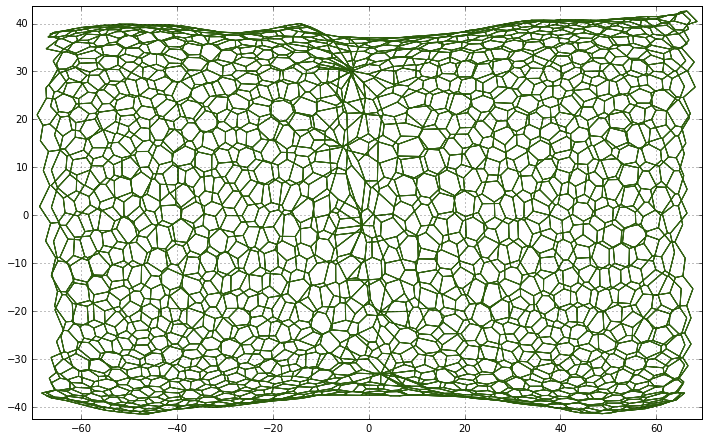

In [46]:
from tyssue.draw.mpl_draw import get_default_draw_specs
draw_specs = get_default_draw_specs()
draw_specs['jv']['visible'] = False
draw_specs['je']['width'] = 0.01


fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(sheet.jv_df.z.min()-1, sheet.jv_df.z.max()+1)
ax.set_ylim(sheet.jv_df.x.min()-1, sheet.jv_df.x.max()+1)
fig.set_size_inches(12, 12)
plt.savefig('test_pola.png')

In [37]:

settings = {
    'norm_factor': 1,
    'minimize': {
        'jac': solver.opt_grad,
        'method': 'L-BFGS-B',
        'options': {'disp': False,
                    'ftol': 1e-6,
                    'gtol': 1e-3},
        }
    }


res = solver.find_energy_min(sheet, geom, model, pos_idx=active_jvs, **settings)
print(res['success'])

True


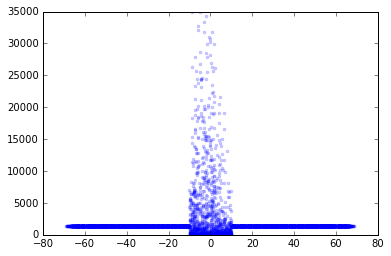

In [42]:
center_jes = sheet.je_df[sheet.upcast_srce(sheet.jv_df['z']).abs() < 10].index

sheet.je_df.loc[center_jes, 'line_tension'] = (sheet.je_df.loc[center_jes, 'line_tension'] * 
                                               (5*np.sin(sheet.je_df.loc[center_jes, 'nz'])**2))

fig, ax = plt.subplots()
ax.plot(sheet.upcast_srce(sheet.jv_df['z']), sheet.je_df['line_tension'], '.', alpha=0.2)

In [43]:
settings = {
    'minimize': {
        'options': {'disp':False,
        'gtol':1e-2},
        'jac': solver.opt_grad
        }
    }
res = solver.find_energy_min(sheet,  geom, model, pos_idx=active_jvs, **settings)
print(res['success'])

True


(-42.06104012501325, 43.594149291748117)

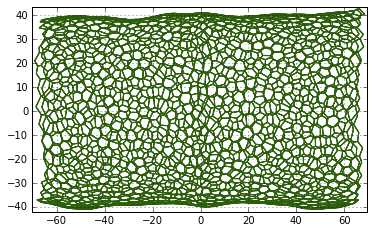

In [30]:
from tyssue.draw.mpl_draw import get_default_draw_specs
draw_specs = get_default_draw_specs()
draw_specs['jv']['visible'] = False
draw_specs['je']['width'] = 0.1 #sheet.je_df.line_tension / sheet.je_df.line_tension.mean()


fig, ax = sheet_view(sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(sheet.jv_df.z.min()-1, sheet.jv_df.z.max()+1)
ax.set_ylim(sheet.jv_df.x.min()-1, sheet.jv_df.x.max()+1)

(-20.946256789780861, 20.749137302389002)

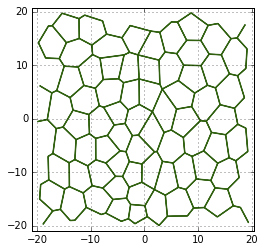

In [31]:
local_mask_jv = (sheet.jv_df.x.abs() < 20) & (sheet.jv_df.z.abs() < 20) & (sheet.jv_df.y > 0)
local_patch_jv = sheet.jv_df[local_mask_jv] 
local_patch_je = sheet.je_df[sheet.upcast_srce(local_mask_jv) & sheet.upcast_trgt(local_mask_jv)]
local_patch_cell = sheet.face_df.loc[np.unique(local_patch_je.face)]
local_datasets = {'jv': local_patch_jv,
                  'je': local_patch_je,
                  'face':local_patch_cell}
local_sheet = Sheet('local', local_datasets)

fig, ax = sheet_view(local_sheet, ['z', 'x'], **draw_specs)
ax.set_xlim(local_sheet.jv_df.z.min()-1, local_sheet.jv_df.z.max()+1)
ax.set_ylim(local_sheet.jv_df.x.min()-1, local_sheet.jv_df.x.max()+1)